In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
import functions as f

In [7]:
model_types = ['regression', 'classification']
model_group_names = ['universal', 'oxide', 'carbon_based', 'nanotube', 'quantum_dot']
model_group_titles = ['universal dataset', 'metal oxide subset', 'carbon-based subset', 'nanotube subset', 'quantum dot subset']

metrics_types = dict()
metrics_types['regression'] = ['R2', 'RMSE', 'MAE']
metrics_types['classification'] = ['F1', 'Accuracy', 'AUC']

plots_types = dict()
plots_types['regression'] = ['error', 'residuals']
plots_types['classification'] = ['ConfusionMatrix', 'PrecisionRecallCurve']

support_classification_plots = ['DiscriminationThreshold', 'ROCAUC']

model_names = dict()
model_names['regression'] = ['lr', 'lasso', 'ridge', 'svm', 'rf', 'et', 'gbr', 'lightgbm']
model_names['classification'] = ['lr', 'knn', 'svm', 'rf', 'et', 'gbc', 'lightgbm']
model_full_names = dict()
model_full_names['regression_lr'] = 'Linear Regressor'
model_full_names['regression_lasso'] = 'Lasso Regressor'
model_full_names['regression_ridge'] = 'Ridge Regressor'
model_full_names['regression_svm'] = 'Support Vector Machine Regressor'
model_full_names['regression_rf'] = 'Random Forest Regressor'
model_full_names['regression_et'] = 'Extra Trees Regressor'
model_full_names['regression_gbr'] = 'Gradient Boosting Regressor'
model_full_names['regression_lightgbm'] = 'Light Gradient Boosting Machine Regressor'
model_full_names['classification_lr'] = 'Logistic Regression Classifier'
model_full_names['classification_knn'] = 'K-Nearest Neighbour Classifier'
model_full_names['classification_svm'] = 'Support Vector Machine Classifier'
model_full_names['classification_rf'] = 'Random Forest Classifier'
model_full_names['classification_et'] = 'Extra Trees Classifier'
model_full_names['classification_gbc'] = 'Gradient Boosting Classifier'
model_full_names['classification_lightgbm'] = 'Light Gradient Boosting Machine Classifier'

0
1
2
3
4
0
1
2
3
4


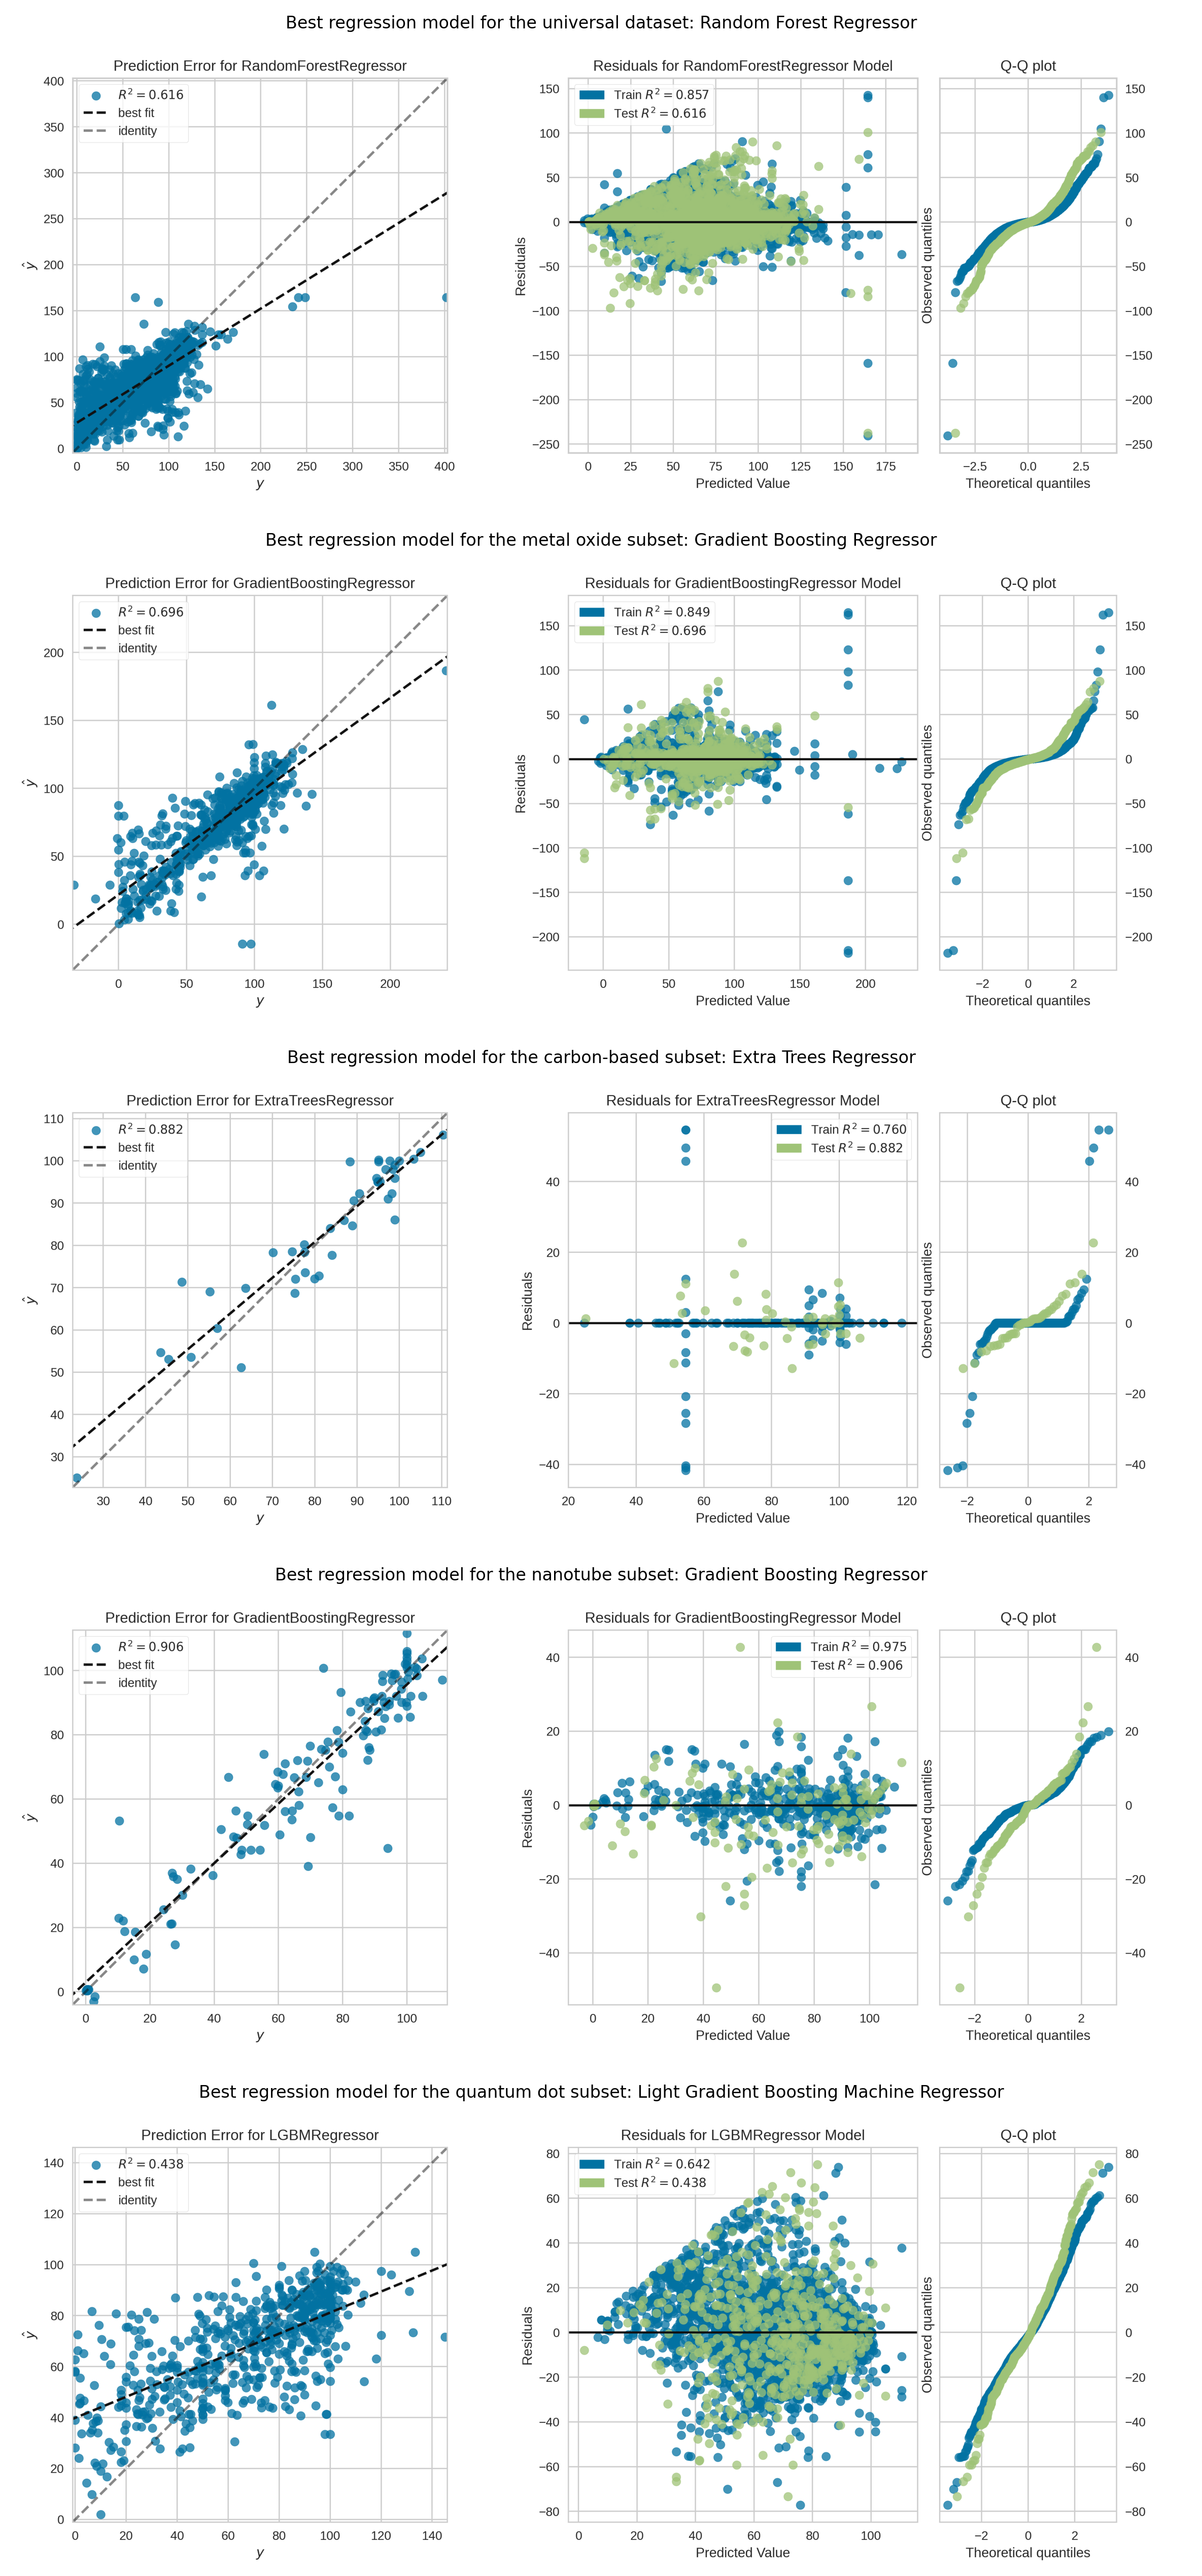

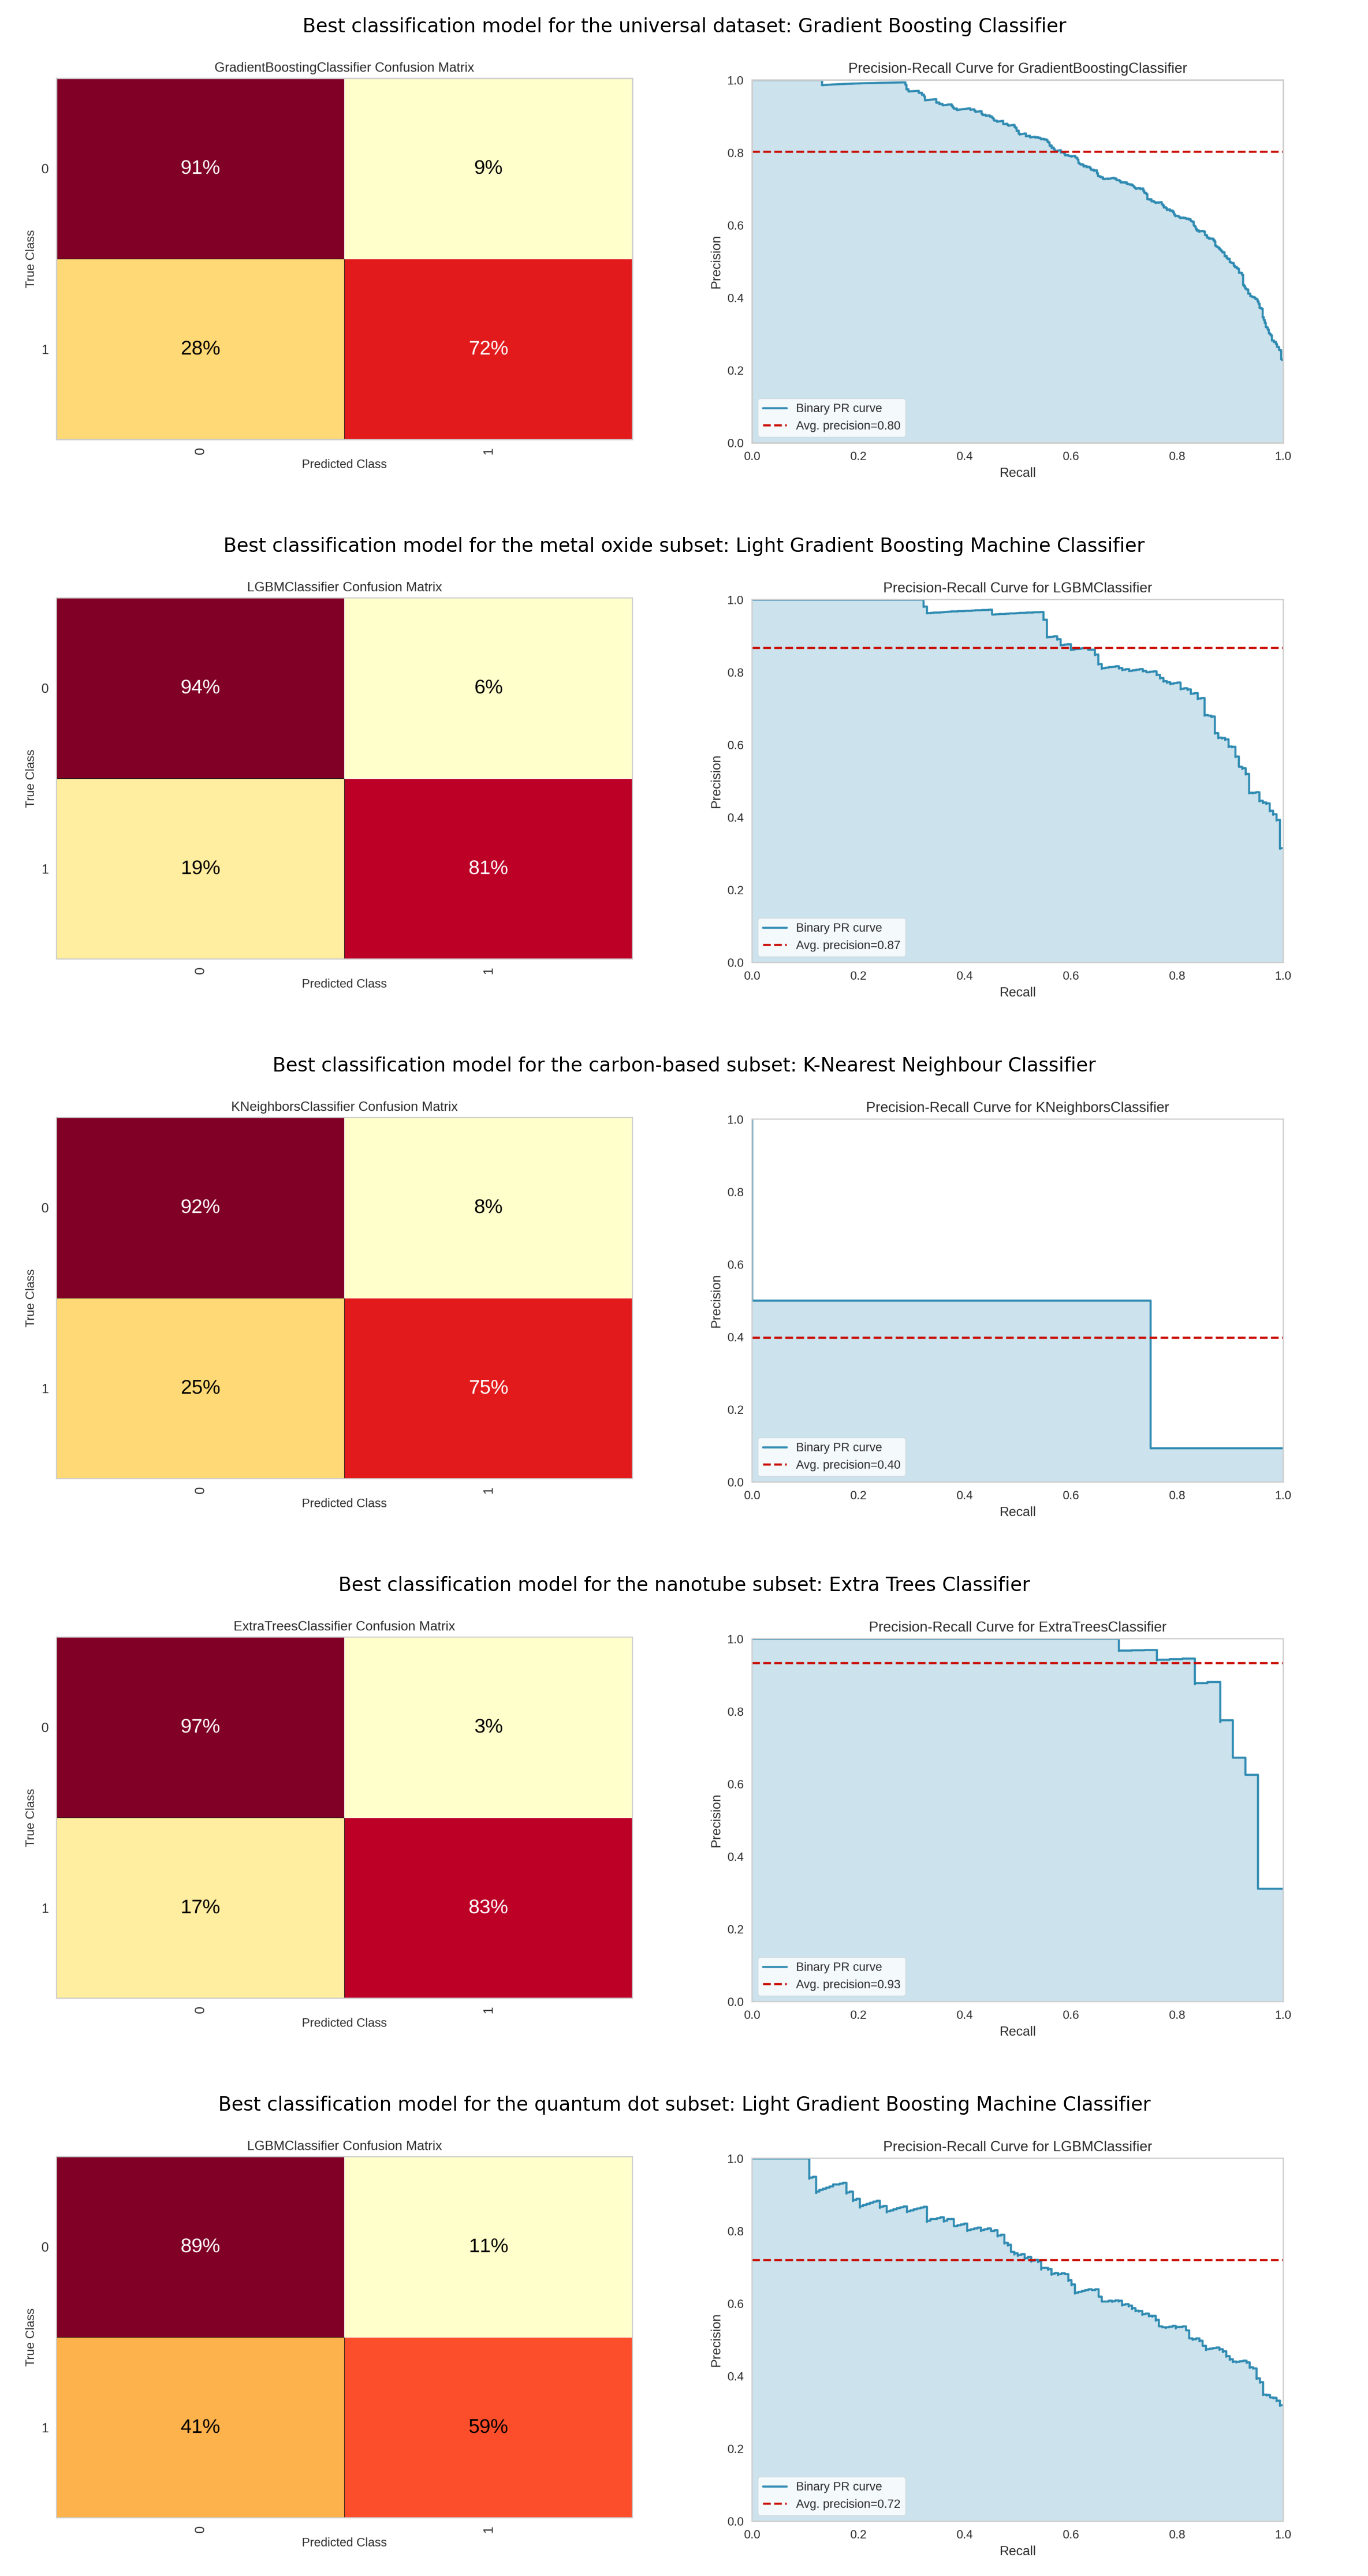

In [5]:
for model_type in model_types:
    
    model_type_splits = dict()
    
    best_models = list()
    
    hyperparameters_dict = dict()

    for model_group_name in model_group_names:
        
        train_df = pd.read_csv('output/datasets/'+model_group_name+'/data_'+model_type+'_train_df.csv', encoding='utf-8')
        test_df = pd.read_csv('output/datasets/'+model_group_name+'/data_'+model_type+'_test_df.csv', encoding='utf-8')
        
        model_type_splits[model_group_name] = [(train_df.shape[0]+test_df.shape[0]),train_df.shape[0],test_df.shape[0]]
        
        model_name_stats = dict()
        
        
        for model_name in model_names[model_type]:
            
            comb_name = ' '.join([model_group_name, model_type, model_name])

            inner_cross_val = pd.read_csv('output/models_results/'+model_group_name+'/' + model_type+'_model_'+model_name+'_tuned_inner_cross_validation_results.tsv', sep='\t', encoding='utf-8', index_col=0)
            outer_cross_val = pd.read_csv('output/models_results/'+model_group_name+'/' + model_type+'_model_'+model_name+'_tuned_outer_cross_validation_results.tsv', sep='\t', encoding='utf-8')
            test_val = pd.read_csv('output/models_results/'+model_group_name+'/' + model_type+'_model_'+model_name+'_test_set_validation_results.tsv', sep='\t', encoding='utf-8')
            
            hyperparams_df = pd.read_csv("output/models_parameters/"+model_group_name+"/" + model_type+"_model_"+model_name+"_hyperparams.tsv",sep='\t', encoding='utf-8', index_col=0)
            hyperparams_df = hyperparams_df.parameter_value.apply(f.round_float)

            model_name_stats[comb_name] = ['/'.join([str(round(inner_cross_val.at['Mean', metrics_types[model_type][0]],2)), str(round(inner_cross_val.at['Std', metrics_types[model_type][0]],2))]),
                                        '/'.join([str(round(outer_cross_val[metrics_types[model_type][0]].mean(),2)), str(round(outer_cross_val[metrics_types[model_type][0]].std(),2))]),
                                        test_val.loc[0][metrics_types[model_type][0]],
                                        '/'.join([str(round(inner_cross_val.at['Mean', metrics_types[model_type][1]],2)), str(round(inner_cross_val.at['Std', metrics_types[model_type][1]],2))]),
                                        '/'.join([str(round(outer_cross_val[metrics_types[model_type][1]].mean(),2)), str(round(outer_cross_val[metrics_types[model_type][1]].std(),2))]),
                                        test_val.loc[0][metrics_types[model_type][1]],
                                        '/'.join([str(round(inner_cross_val.at['Mean', metrics_types[model_type][2]],2)), str(round(inner_cross_val.at['Std', metrics_types[model_type][2]],2))]),
                                        '/'.join([str(round(outer_cross_val[metrics_types[model_type][2]].mean(),2)), str(round(outer_cross_val[metrics_types[model_type][2]].std(),2))]),
                                        test_val.loc[0][metrics_types[model_type][2]] ]
            
            if(model_name not in hyperparameters_dict.keys()):
                hyperparameters_dict[model_name] = list()

            hyperparameters_dict[model_name].append(hyperparams_df)
            
        
        # models tables for each group
                
        model_name_stats_df = pd.DataFrame(model_name_stats, index=['Inner CV R2 (mean/std)',
                                                                    'Outer CV R2 (mean/std)',
                                                                    'Test Set validation R2',
                                                                   'Inner CV RMSE (mean/std)',
                                                                   'Outer CV RMSE (mean/std)',
                                                                   'Test Set validation RMSE',
                                                                   'Inner CV MAE (mean/std)',
                                                                   'Outer CV MAE (mean/std)',
                                                                   'Test Set validation MAE'])
        
        model_name_stats_df.to_csv('output/tables_and_figures/'+model_type+'_'+model_group_name+'_results.tsv', encoding="utf-8", sep="\t")
        
        best_model = model_name_stats_df.iloc[[2]].apply(pd.to_numeric).idxmax(axis=1)[0]
        best_model = best_model.split(' ')[2]
        best_models.append(best_model)
        
        
    # Models hyperparameters
    for model_name in model_names[model_type]:
            model_name_hyperparams_df = pd.concat(hyperparameters_dict[model_name], axis=1)
            
            """
            # drop rows with the same value
            unique_vals_in_rows = list(map(set,model_name_hyperparams_df.values))
            
            unique_vals_in_row_index = 0
            rows_to_drop = list()
            
            for unique_vals_in_row in unique_vals_in_rows:
                if(len(unique_vals_in_row) == 1):
                    rows_to_drop.append(unique_vals_in_row_index)
                unique_vals_in_row_index = unique_vals_in_row_index + 1
            model_name_hyperparams_df.drop([model_name_hyperparams_df.index[x] for x in rows_to_drop], inplace=True)   

            print(model_type + " _ " + model_name)
            print(model_name_hyperparams_df.shape)
            """
            
            model_name_hyperparams_df.columns = [x + " model" for x in model_group_titles]
            model_name_hyperparams_df.to_csv('output/tables_and_figures/'+model_type+'_'+model_name+'_hyperparams.tsv', encoding="utf-8", sep="\t")

        
    # regression/classification splits counts
    model_type_splits_df = pd.DataFrame(model_type_splits, index=['Total number of instances',
                                                                 'Number of training instances',
                                                                 'Number of test instances'])
    model_type_splits_df.to_csv('output/tables_and_figures/'+model_type+'_data_splits.tsv', encoding="utf-8", sep="\t")
    
    
    # Make the plots

    if(model_type == 'regression'):
        fig = plt.figure(figsize=(8, 17), dpi=300)
    else:
        fig = plt.figure(figsize=(8, 15), dpi=300)
    
    rows = 5
    columns = len(plots_types[model_type])
    
    subfigs = fig.subfigures(nrows=rows, ncols=1)
    
    for row, subfig in enumerate(subfigs):
        
        print(row)
        
        subfig.suptitle(f'Best {model_type} model for the {model_group_titles[row]}: {model_full_names[model_type+"_"+best_models[row]]}',fontsize=8)
        
        if(model_type == 'regression'):
            axs = subfig.subplots(nrows=1, ncols=columns, gridspec_kw={'width_ratios': [1, 1.6]})
        else:
            axs = subfig.subplots(nrows=1, ncols=columns, gridspec_kw={'width_ratios': [1, 1.1]})

        plot_idx = 0
        
        for col, ax in enumerate(axs):

            read_img = mpimg.imread("output/plots/"+model_group_names[row]+"/" + model_type + "_model_"+best_models[row]+"_"+plots_types[model_type][plot_idx]+"_plot.png")
            
            if(model_type == 'regression'):
                read_img = read_img[50:1600, :, :]
            
            if(plots_types[model_type][plot_idx] == 'error'):
                read_img = read_img[:, 400:1900, :]
                
            if(plots_types[model_type][plot_idx] == 'PrecisionRecallCurve'):
                read_img = read_img[100:1600, :, :]
            
            ax.imshow(read_img)
            ax.axis('off')
            #plt.title("First")

            plot_idx = plot_idx + 1

        plt.tight_layout()

    fig.savefig('output/tables_and_figures/best_'+model_type+'_model_plots.png', dpi=300)


0
1
2
3
4


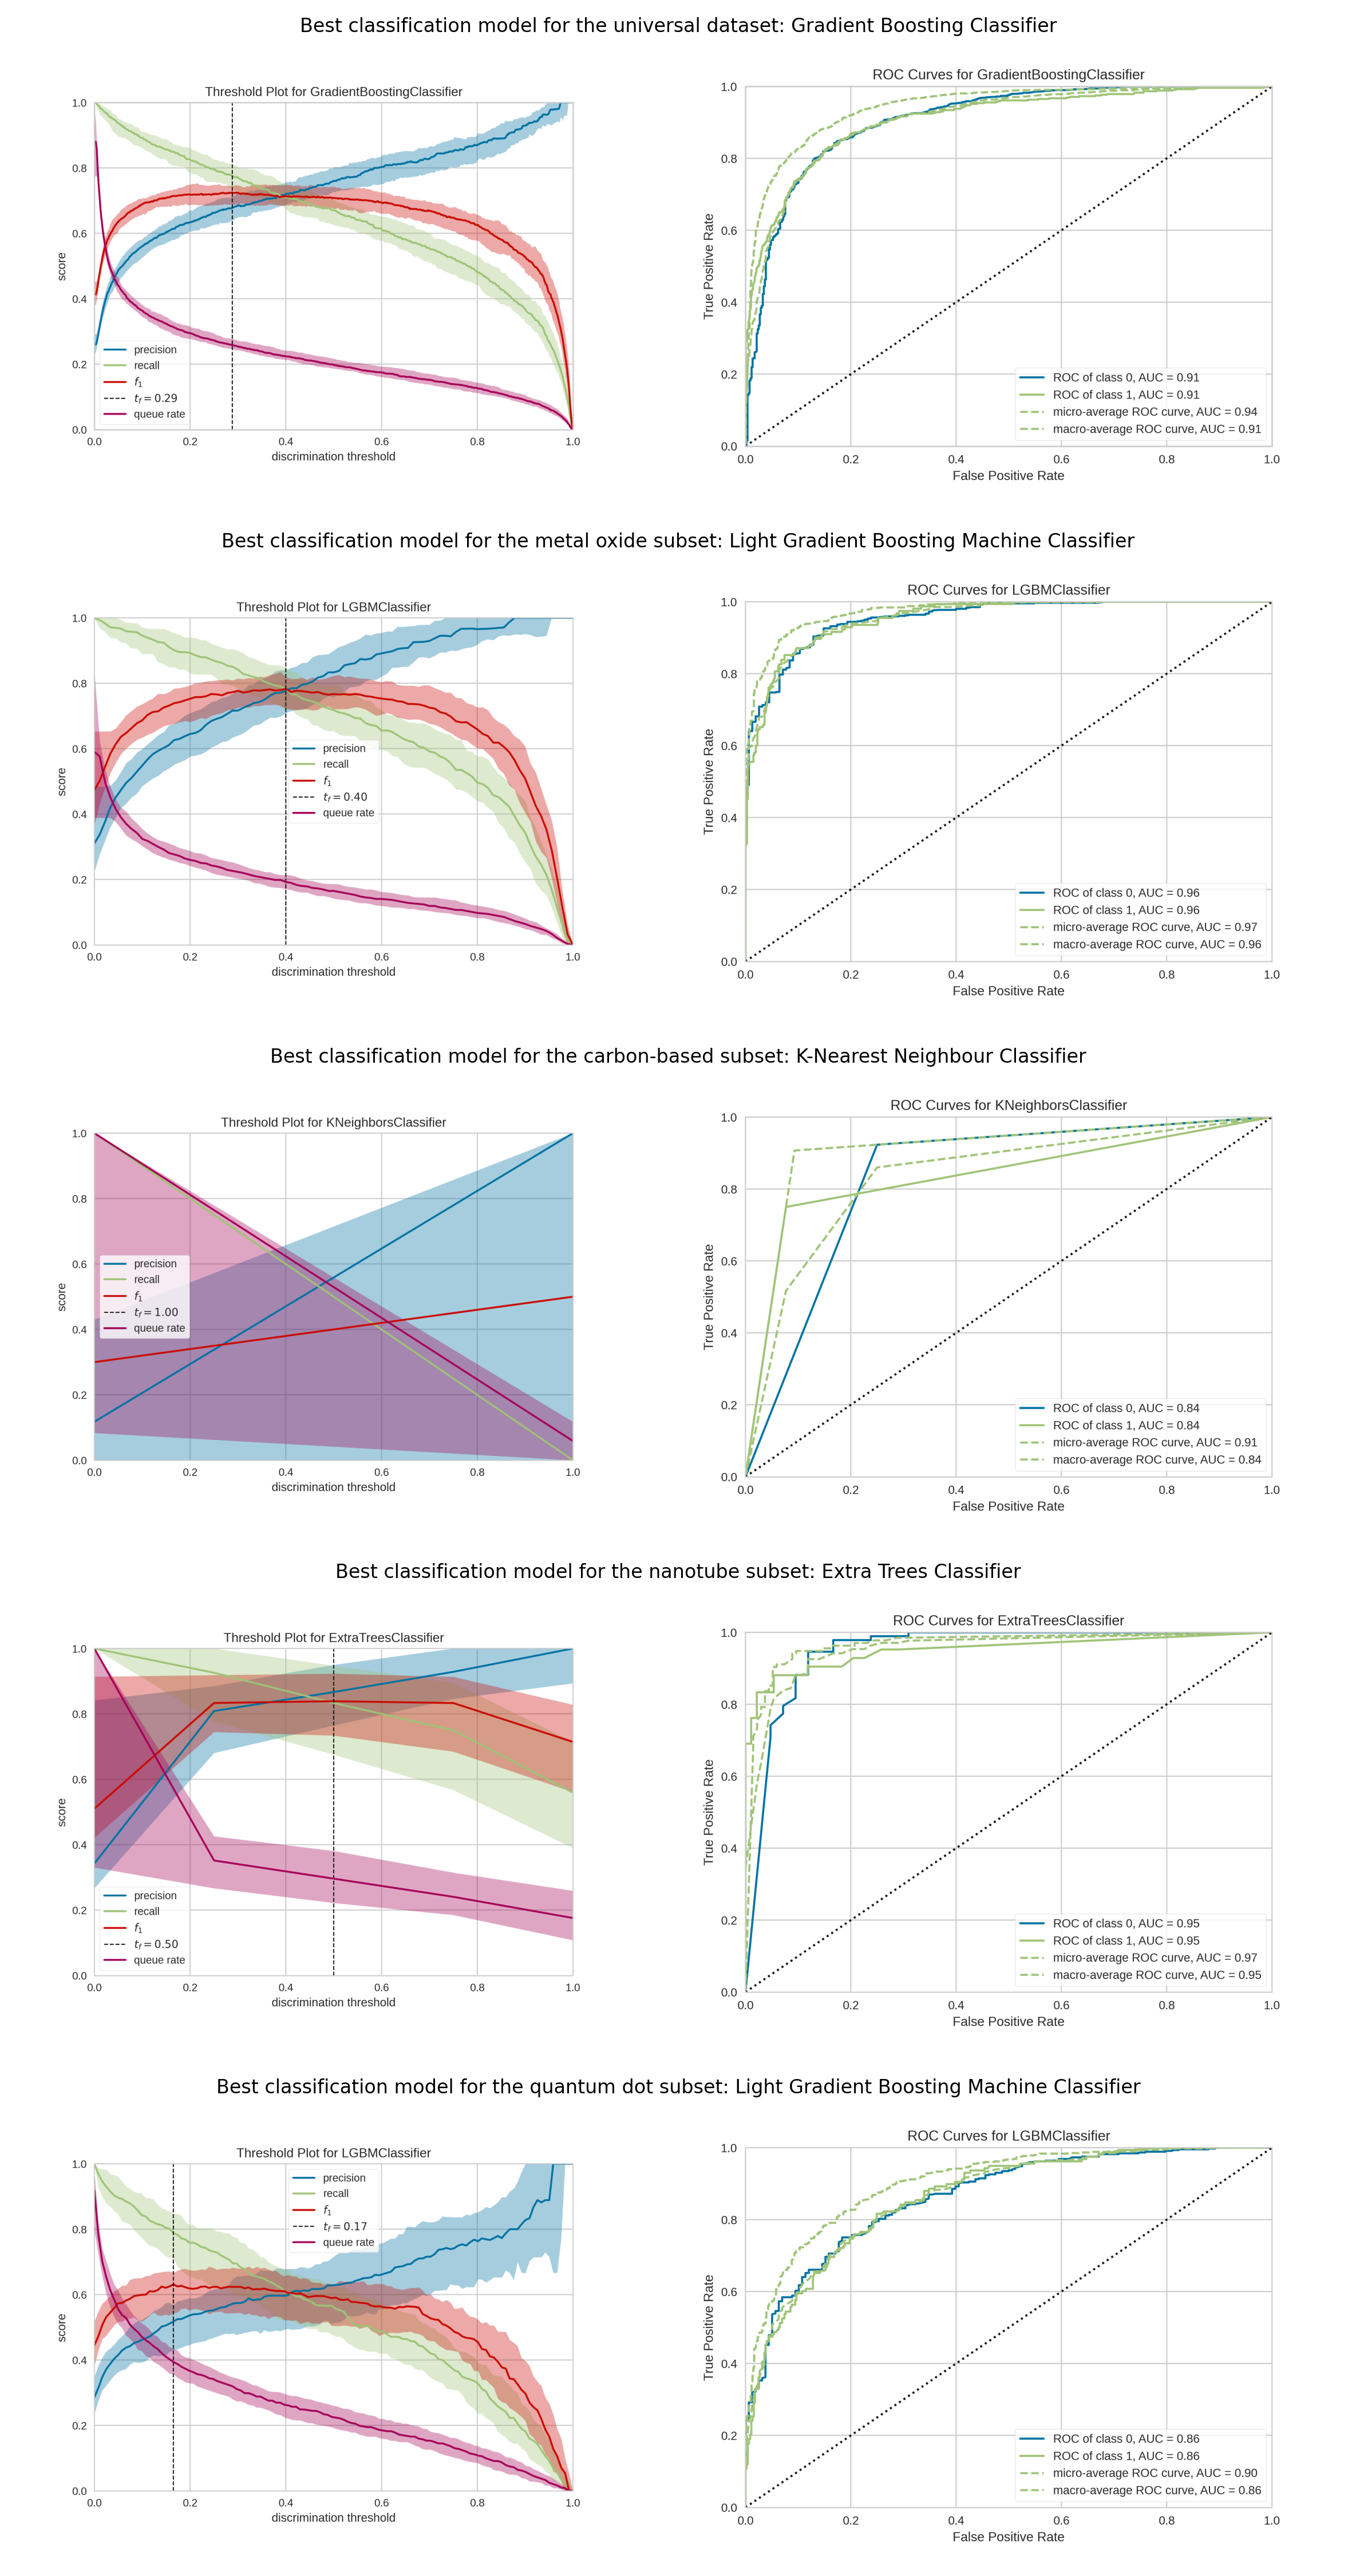

In [9]:

fig = plt.figure(figsize=(8, 15), dpi=300)

rows = 5
columns = len(support_classification_plots)

subfigs = fig.subfigures(nrows=rows, ncols=1)

for row, subfig in enumerate(subfigs):

    print(row)

    subfig.suptitle(f'Best classification model for the {model_group_titles[row]}: {model_full_names[model_type+"_"+best_models[row]]}',fontsize=8)

    axs = subfig.subplots(nrows=1, ncols=columns, gridspec_kw={'width_ratios': [1, 1.1]})

    plot_idx = 0

    for col, ax in enumerate(axs):

        read_img = mpimg.imread("output/plots/"+model_group_names[row]+"/" + model_type + "_model_"+best_models[row]+"_"+support_classification_plots[plot_idx]+"_plot.png")

        ax.imshow(read_img)
        ax.axis('off')
        #plt.title("First")

        plot_idx = plot_idx + 1

    plt.tight_layout()

fig.savefig('output/tables_and_figures/best_classification_model_support_plots.png', dpi=300)